In [70]:
from pathlib import Path
import ants
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage.util import montage
import skimage.morphology as morph
import skimage.measure as meas
from natsort import natsorted 

def show_cbfratio(cbf_ratio, filename=None, cmap='jet', vmin=0,vmax=1):
    m_ = montage(np.transpose(cbf_ratio, axes=(2,1,0)), grid_shape=(5,length_z//5))
    f,ax = plt.subplots(figsize=(10,10))
    ax.set_axis_off()
    img2show = ax.imshow(m_, cmap=cmap, vmin=vmin, vmax=vmax)    
    f.colorbar(img2show, ax=ax, shrink=0.5, pad=0.05)
    if filename is not None:
        f.savefig(filename, dpi=150)

def calc_log_HI(cbf_before_array, cbf_after_array, 
                spacing=(1,1,1), thresh_cbf_ratio=2.0, thresh_vol=100, connective_mode=2,
               return_mask=False):
    vol_voxel = np.prod(spacing)
    cbf_ratio = cbf_after_array / cbf_before_array
    cbf_ratio[np.isnan(cbf_ratio)] = 0.
    cbf_ratio[np.isinf(cbf_ratio)] = 0.
    cbf_ratio[cbf_ratio<0] = 0.
    length_z = cbf_ratio.shape[-1]
    mask = (cbf_ratio > thresh_cbf_ratio).astype(np.uint8)
    # Connected components with connectivity 2 (aka 3D 26 connectivity) 
    labs= meas.label(mask, connectivity=connective_mode,)
    reg_list = meas.regionprops(labs)
    masks_eff_region = [] # effective masks list
    eff_regions_vals = [] 
    if len(reg_list) < 1:
        log_HI = -1
    else:
        volumes_each_component = [vol_voxel*f.num_pixels for f in reg_list]
        lab_idx_sorted = natsorted(range(len(reg_list)),key=lambda x: volumes_each_component[x], reverse=True)
        for lab_idx in lab_idx_sorted:
            if volumes_each_component[lab_idx] > 100:
                eff_regions_vals.append(lab_idx+1)
            else: break
        for eff_region_val in eff_regions_vals:
            masks_eff_region.append((labs == eff_region_val).astype(np.uint8))
        eff_vol = 0.
        for mask_eff in masks_eff_region:
            eff_vol += np.sum(cbf_ratio[mask_eff>0] * vol_voxel)
        log_HI = np.log10(eff_vol)
    if return_mask:
        return log_HI, masks_eff_region 
    else:return log_HI

## Calculate Hyper perfusion index(HI):
    1. CBR ratio map: after / before
    2. Effective Hyper-perfusion region: CBF ratio > 2 and volume > 100 mm^3 (connective volumes)
    3. weighted-sum: log(sum(CBF ratio * volume) )
    4. if log10(HI) > 4.5, hyper-perfusion = 1

In [71]:
data_dir = Path("/root/onethingai-tmp/mtunet_dataset/")
pdir_list = natsorted([f for f in data_dir.iterdir()])
for pdir in pdir_list:
    cbf_before_fp = pdir.joinpath("cbf_before.nii.gz")
    cbf_after_fp = pdir.joinpath("cbf_after.nii.gz")
    cbf_before = ants.image_read(str(cbf_before_fp))
    cbf_after = ants.image_read(str(cbf_after_fp))
    cbf_before_array = cbf_before.numpy()
    cbf_after_array = cbf_after.numpy()
    cbf_ratio = cbf_after_array / cbf_before_array
    cbf_ratio[np.isnan(cbf_ratio)] = 0.
    cbf_ratio[np.isinf(cbf_ratio)] = 0.
    cbf_ratio[cbf_ratio<0] = 0.
    length_z = cbf_ratio.shape[-1]
    vmin = np.percentile(cbf_ratio[cbf_ratio>0], 10)
    vmax = np.percentile(cbf_ratio[cbf_ratio>0], 99)
    log_HI = calc_log_HI(cbf_before_array, cbf_after_array, spacing=(cbf_before.spacing))
    print(pdir.name, log_HI)
    # break
    
    # print(np.isnan(cbf_ratio))
    # ants.plot(cbf_ratio, cmap='jet', cbar=True,
    #       # overlay=cbf_after,
    #       # overlay_alpha=0.35,overlay_cmap='Reds',
    #       # vminol=0,vmaxol=100,
    #       axis=2,nslices=16,ncol=4,
    #       filename=str(pdir.joinpath("cbf_ratio"+".png")),dpi=100)

/tmp/ipykernel_4385/3634008085.py:10: RuntimeWarning: divide by zero encountered in divide
  cbf_ratio = cbf_after_array / cbf_before_array
/tmp/ipykernel_4385/3634008085.py:10: RuntimeWarning: invalid value encountered in divide
  cbf_ratio = cbf_after_array / cbf_before_array
/tmp/ipykernel_4385/4134856212.py:24: RuntimeWarning: divide by zero encountered in divide
  cbf_ratio = cbf_after_array / cbf_before_array
/tmp/ipykernel_4385/4134856212.py:24: RuntimeWarning: invalid value encountered in divide
  cbf_ratio = cbf_after_array / cbf_before_array


90
subject_1 2.6800735717646047
141
subject_2 4.615875364158331
289
subject_3 4.753199042477934
200
subject_4 4.144364365010131
44
subject_5 3.0841414944894128
172
subject_6 4.404256604860837
186
subject_7 5.9843130070015125
377
subject_8 5.240217552551705
138
subject_9 4.41211429164306
157
subject_10 4.493432082492383
180
subject_11 4.840604977284178
116
subject_12 5.34162963869508
180
subject_13 4.418204031012311
72
subject_14 3.646603600395448
355
subject_15 5.4894472510299
139
subject_16 4.045004989350234
188
subject_17 5.578804542091943
110
subject_18 4.543677783525121
339
subject_19 5.534587857966814
260
subject_20 4.543441066310667
134
subject_21 5.658263478039241
449
subject_22 5.374576978659235
376
subject_23 4.47399906395431
448
subject_24 5.573371611213402
189
subject_25 4.732778862315409
84
subject_26 4.626515311195341
63
subject_27 3.6907248477534473
198
subject_28 4.286346471365815
92
subject_29 6.354363354363521
386
subject_30 5.041044822569895
260
subject_31 4.981046685

In [61]:
np.sum(cbf_ratio[mask_eff>0] * vol_voxel)

478.71118

In [63]:
eff_vol

478.711181640625

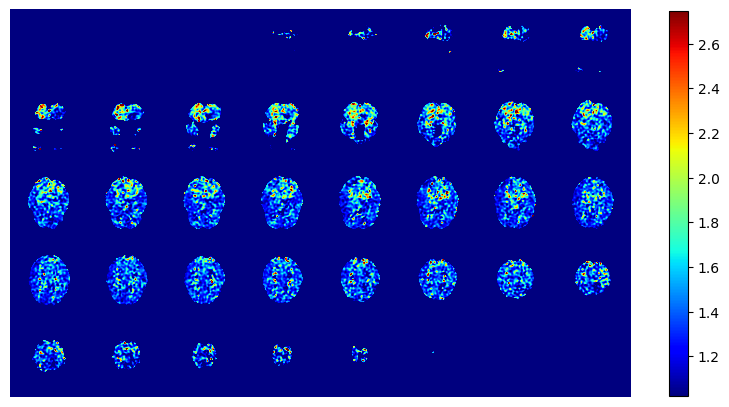

In [8]:
show_cbfratio(cbf_ratio)

In [72]:
cbf_before.spacing

(1.875, 1.875, 4.0)